# Kaggle Titanic survival prediction

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Loading some functions

In [4]:
# %load functions.py

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def process_df(df) :
    df = process_missing(df)
    df = process_age(df) 
    df = process_fare(df)
    df = process_titles(df) 
    df = process_cabin(df)
    
    cols = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for col in cols :
        df = create_dummies(df, col)
    return df

In [6]:
train = process_df(train)
holdout = process_df(holdout)

### Exploring the data

<AxesSubplot:>

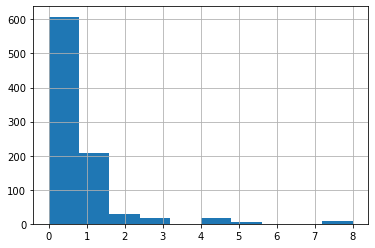

In [7]:
train["SibSp"].hist()

<AxesSubplot:>

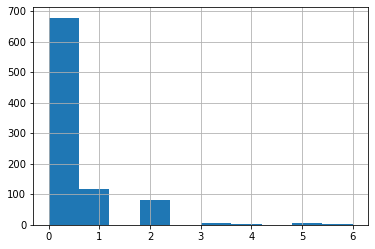

In [8]:
train["Parch"].hist()

In [9]:
# We can combine these 2 columns to get the size of the family

train["familysize"] = train[["SibSp","Parch"]].sum(axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,familysize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,0


In [10]:
# Function defining if a passenger has family members on board

def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

In [11]:
train = process_isalone(train)
holdout = process_isalone(holdout)

### Feature selection

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Title               

In [14]:
def select_features(df) :
    df = df.select_dtypes(exclude=['object', 'category'])
    df = df.dropna(axis = 1)
    all_X = df.drop(columns = ["PassengerId", "Survived"], axis = 1)
    all_y = df['Survived']
    
    RFC = RandomForestClassifier(random_state = 1)
    selector = RFECV(RFC, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    print(optimized_columns)
    return optimized_columns

In [15]:
optimized_columns = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


### Algorithm selection

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
def select_model(df, features) :
    all_X = df[features]
    all_y = df['Survived']
    m1 = {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        }
    m2 = {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
                }
        }
    m3 = {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
                }
        }
    models = [m1, m2, m3]
    scores = []
    
    
    for i in models : 
        print(i["name"])        
        clf = GridSearchCV(i["estimator"], param_grid = i["hyperparameters"], cv = 10)
        clf.fit(all_X, all_y)
        i["best_params"] = clf.best_params_
        i["best_score"] = clf.best_score_
        scores.append(i["best_score"])
        if i["best_score"] == max(scores) :
            final_model = i
        
        print(final_model)
      
    print("\nscores : ")
    print(scores)
    print("\nbest score : ")
    print(max(scores))
        
    return models, final_model

In [18]:
results, final_result = select_model(train, optimized_columns)

print("\nresults : ")
print(results)
print("\nfinal_result : ")
print(final_result)

LogisticRegression


C:\Users\pnassif\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pnassif\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

{'name': 'LogisticRegression', 'estimator': LogisticRegression(), 'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'best_params': {'solver': 'lbfgs'}, 'best_score': 0.8204744069912608}
KNeighborsClassifier
{'name': 'LogisticRegression', 'estimator': LogisticRegression(), 'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'best_params': {'solver': 'lbfgs'}, 'best_score': 0.8204744069912608}
RandomForestClassifier
{'name': 'RandomForestClassifier', 'estimator': RandomForestClassifier(random_state=1), 'hyperparameters': {'n_estimators': [4, 6, 9], 'criterion': ['entropy', 'gini'], 'max_depth': [2, 5, 10], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [1, 5, 8], 'min_samples_split': [2, 3, 5]}, 'best_params': {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}, 'best_score': 0.8395505617977527}

scores : 
[0.8204744069912608, 0.7767041198501874, 0.8395505617977527]

best

### Submission

In [31]:
def save_submission_file(model, features, filename) :
    
    mod = model["estimator"]
    mod.fit(train[features], train["Survived"])
    predictions = mod.predict(holdout[features])
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                     "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

In [32]:
save_submission_file(final_result, optimized_columns, "output1.csv")